### Library imports


In [3]:
!pip install -q wandb umap-learn scikit-learn seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split,GridSearchCV
import random
import wandb

In [4]:
wandb.login()

wandb: Currently logged in as: sofea-utbm (sofeasuhaimi-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
    project="DS50_ventilator-pressure-prediction",
    name="eda-and-preprocessing-latest",
    config={
        "framework": "PyTorch",
        "scaling": "MinMax",
        "dimension_reduction": "UMAP/TSNE",
        "models": ["MLP", "GRU", "LSTM", "Transformer"]
    }
)

In [5]:
df_train = pd.read_csv('train.csv', index_col = 'id')
df_test= pd.read_csv('test.csv', index_col = 'id')

In [6]:
df_train.shape

(6036000, 7)

In [ ]:
df_train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
# Log the first 100 rows to wandb as a table
wandb.log({"Sample data table": wandb.Table(dataframe=df_train.head(100))})

In [ ]:
df_train.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6036000 entries, 1 to 6036000
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
 6   pressure   float64
dtypes: float64(3), int64(4)
memory usage: 368.4 MB


In [ ]:
#Working with a sample of 1000
df_train = df_train.head(5000)
df_test = df_train.head(1000)

## Exploratory Data Analysis (EDA) & Cleaning

In [ ]:
df_train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


Step 1: Checking for duplicates

In [ ]:
print("Number of duplicates in dataset:", df_train.duplicated().sum())


Number of duplicates in dataset: 0


Step 2: Handling missing values

In [ ]:
# Percentage of missing values
((df_train.isnull().sum()/df_train.shape[0])*100).sort_values(ascending=False)

,0
breath_id,0.0
R,0.0
C,0.0
time_step,0.0
u_in,0.0
u_out,0.0
pressure,0.0


In [ ]:
print(wandb.run)


In [ ]:
# Start a new run
wandb.init(project="DS50_ventilator-pressure-prediction", name="missing-values-run")

# Check for missing values
missing_values = df_train.isnull().sum()
# Convert to a proper DataFrame with named columns
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'Missing_Count']

wandb.log({"Missing Values": wandb.Table(dataframe=missing_df)})

wandb.finish()

Step 3: Observe the structure of data

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   breath_id  1000 non-null   int64  
 1   R          1000 non-null   int64  
 2   C          1000 non-null   int64  
 3   time_step  1000 non-null   float64
 4   u_in       1000 non-null   float64
 5   u_out      1000 non-null   int64  
 6   pressure   1000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 62.5 KB


In [ ]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']
num_cols = [col for col in df_train.columns if df_train[col].dtype != 'object']

In [ ]:
for col in num_cols:
    print(f"{col} has {df_train[col].nunique()} values : {df_train[col].unique()} \n")

breath_id has 13 values : [ 1  2  3  4  5  6  7  9 10 12 13 14 15] 

R has 3 values : [20 50  5] 

C has 2 values : [50 20] 

time_step has 988 values : [0.         0.03365231 0.06751442 0.10154223 0.13575554 0.16969776
 0.20370793 0.23772264 0.27177644 0.30573177 0.33967495 0.37368035
 0.40765023 0.44180417 0.47610283 0.5099957  0.54404068 0.57817888
 0.61210942 0.64605474 0.68017578 0.71532679 0.74934411 0.78324103
 0.81739712 0.85141063 0.88548803 0.9194684  0.95354748 0.98748708
 1.02129793 1.05542588 1.08940387 1.12338662 1.15759063 1.19150996
 1.22557068 1.25953102 1.29362202 1.32763076 1.36164641 1.39561462
 1.42967796 1.46390295 1.49795914 1.53198147 1.56597924 1.59987783
 1.63412333 1.66814089 1.70218062 1.73603678 1.77004766 1.80400276
 1.83804607 1.87192035 1.9059608  1.93999124 1.97400165 2.00806665
 2.04223061 2.0765419  2.1105473  2.1447494  2.17875218 2.21296263
 2.24704528 2.28127289 2.31531334 2.34945726 2.3834579  2.41755342
 2.45147347 2.48558688 2.51950169 2.5535934

### Visualize outliers for u_in

*   Main control input to the ventilator (input airflow).
*   Irregular spikes can skew the model.
*   There are so many types of values for u_in compare to the other features




Outliers in u_in: 122


Number of Outliers (u_in),▁
Number of Outliers (u_in),122


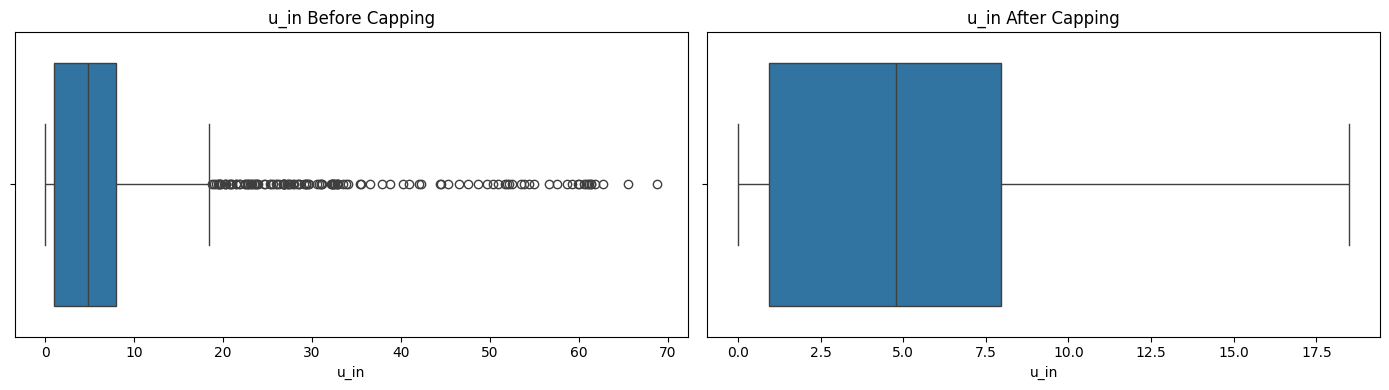

In [ ]:
# Start a new run for outlier analysis
wandb.init(project="DS50_ventilator-pressure-prediction", name="outlier-analysis-run")

# IQR method for 'u_in'
Q1 = df_train['u_in'].quantile(0.25)
Q3 = df_train['u_in'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (df_train['u_in'] < lower_bound) | (df_train['u_in'] > upper_bound)
num_outliers = outlier_mask.sum()

print(f"Outliers in u_in: {num_outliers}")

# Log number to wandb
wandb.log({"Number of Outliers (u_in)": num_outliers})

# Visualize before and after capping
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot(x=df_train['u_in'], ax=axs[0])
axs[0].set_title("u_in Before Capping")

# Cap outliers (soft fix)
df_train.loc[df_train['u_in'] > upper_bound, 'u_in'] = upper_bound
df_train.loc[df_train['u_in'] < lower_bound, 'u_in'] = lower_bound

sns.boxplot(x=df_train['u_in'], ax=axs[1])
axs[1].set_title("u_in After Capping")

plt.tight_layout()
wandb.log({"u_in Outlier Boxplots": wandb.Image(plt)})

wandb.finish()


**Displaying two boxplots of the u_in feature (air being pushed into the lung):**

u_in Before Capping

*   Shows the original distribution of u_in.
*   There are many extreme outliers, going up to 100+, even though most values are clustered between 0–10.\
*   The box is squished on the left, and the plot is dominated by the long tail (outliers).

u_in After Capping

*   Replaced extreme values with the upper_bound or lower_bound.
*   Now, the distribution looks much cleaner and more centered, without those extreme long tails.
*   This plot is more readable and more suitable for modeling.

**This is a univariate outlier detection method — it only looks at u_in in isolation, without considering time or other variables like u_out, R, C.**

**In a deep learning context, we don’t care whether a single value looks statistically odd in isolation. We care if the model can learn consistent patterns across all features combined over time. So even if u_in seems "high" , it may not be an outlier when seen in context (e.g., during inspiration phase with u_out = 0 and certain R, C).**



### Visualize u_in over time for different breaths

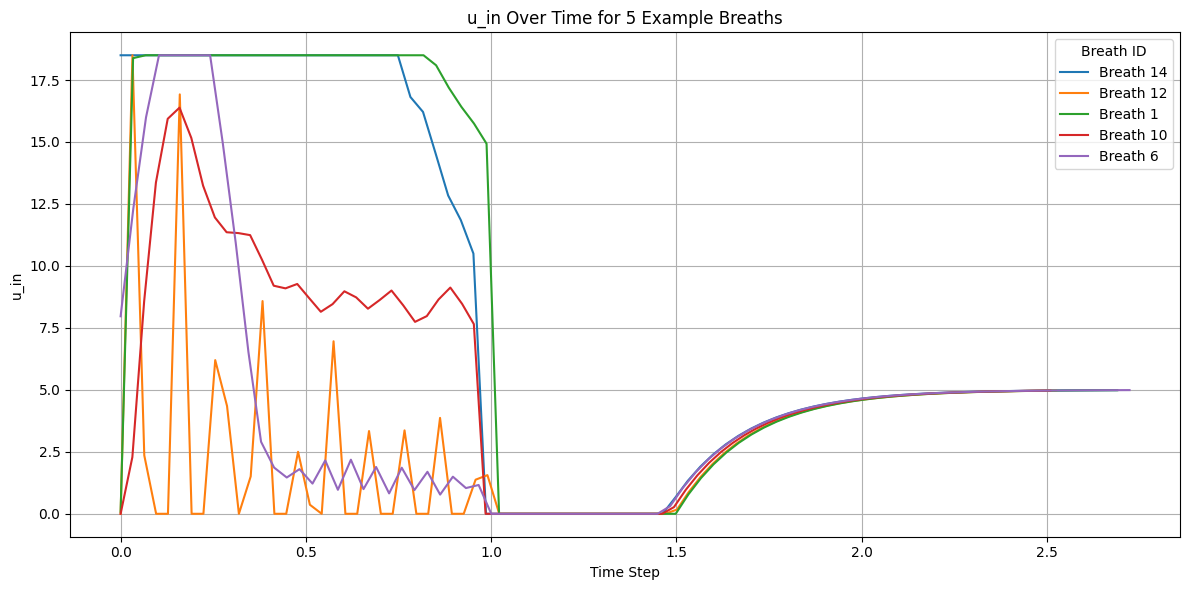

In [ ]:
# Initialize a new WandB run
wandb.init(project="DS50_ventilator-pressure-prediction", name="u_in-sequence-visualization")

# Choose a few unique breath IDs (e.g. 5 random samples)
example_breath_ids = df_train['breath_id'].drop_duplicates().sample(5, random_state=42).values

# Create the plot
plt.figure(figsize=(12, 6))
for breath_id in example_breath_ids:
    sample = df_train[df_train['breath_id'] == breath_id]
    plt.plot(sample['time_step'], sample['u_in'], label=f'Breath {breath_id}')

plt.title("u_in Over Time for 5 Example Breaths")
plt.xlabel("Time Step")
plt.ylabel("u_in")
plt.legend(title="Breath ID")
plt.grid(True)

# Log to WandB
wandb.log({"u_in Time Series Visualization": wandb.Image(plt)})

# Close plot and finish WandB run
plt.tight_layout()
plt.show()
wandb.finish()


Initial IQR analysis marked some high u_in values as outliers. However, after plotting u_in across multiple breaths, we observed that these values are part of the normal inhalation phase.
Since deep learning models treat input features jointly, not individually, and our dataset is sequential, these values were retained as-is for training.

### Visualize pressure over time for different breaths

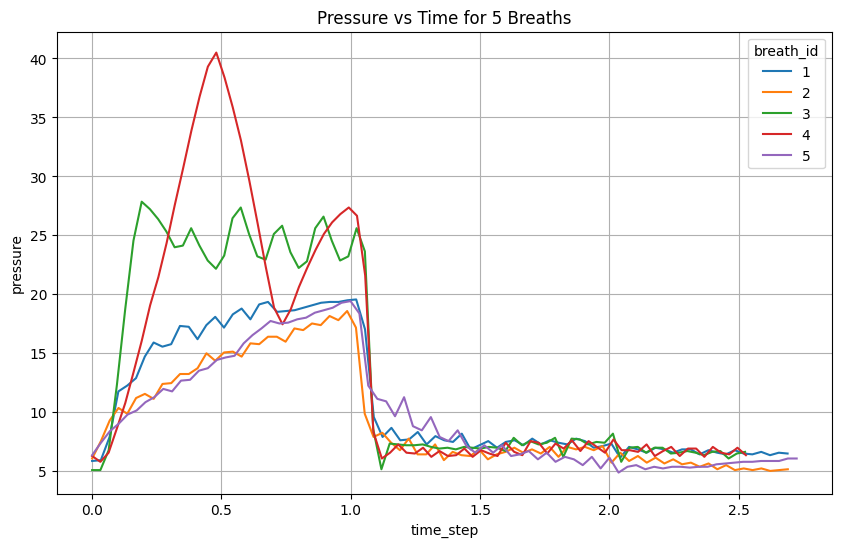

In [ ]:
# Load dataset
df = pd.read_csv("train.csv")

# Pick a few breaths
sample_breaths = df[df['breath_id'].isin(df['breath_id'].unique()[:5])]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=sample_breaths, x='time_step', y='pressure', hue='breath_id', palette='tab10')
plt.title("Pressure vs Time for 5 Breaths")
plt.xlabel("time_step")
plt.ylabel("pressure")
plt.grid(True)
plt.show()


### Check timestamp ordering

In [ ]:
# Start a wandb run for timestamp inspection
wandb.init(project="DS50_ventilator-pressure-prediction", name="timestamp-analysis")

# Select one random breath
breath_id = random.choice(df_train['breath_id'].unique())
sample_breath = df_train[df_train['breath_id'] == breath_id]

# Ensure time_step is strictly increasing
time_diff = sample_breath['time_step'].diff().dropna()
is_regular = time_diff.nunique() == 1
mean_interval = time_diff.mean()

print(f"Time intervals are consistent: {is_regular}")
print(f"Average interval: {mean_interval:.4f}")

wandb.log({
    "Time Step Consistent": is_regular,
    "Average Interval": mean_interval
})


Time intervals are consistent: False
Average interval: 0.0340


**Time series models like GRU, LSTM, and Transformers usually assume:**
*   Input is sampled at fixed time intervals (like a heartbeat).
*   Each row = next time step.

**If your time_step is not consistent, then:**
*   The model will be confused, unless you help it understand the timing.
*   Some intervals might be faster/slower than others, affecting learning.

***mean interval is ~0.0317 — pretty stable***





### Plot Time-Series Signal of One Breath

Average Interval,▁
Average Interval,0.03403
Time Step Consistent,False


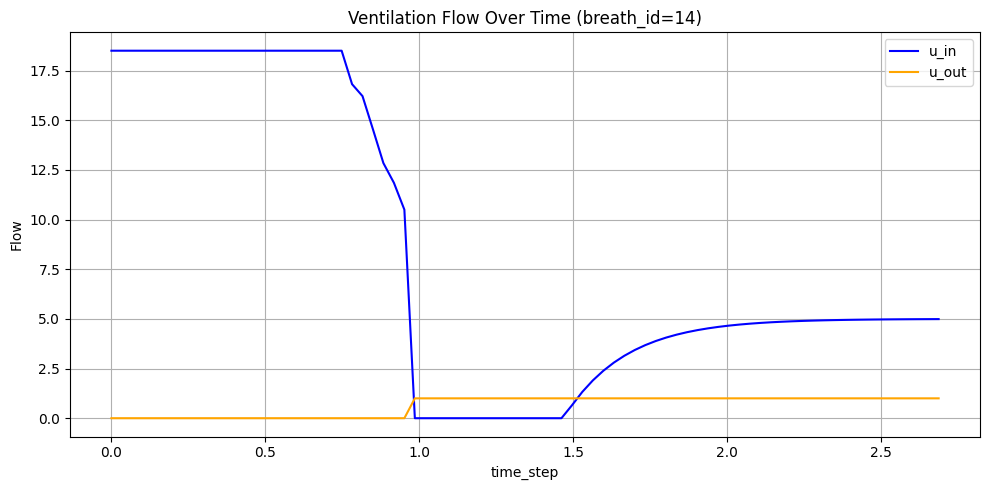

In [ ]:
# Plot u_in and u_out over time
plt.figure(figsize=(10, 5))
plt.plot(sample_breath['time_step'], sample_breath['u_in'], label='u_in', color='blue')
plt.plot(sample_breath['time_step'], sample_breath['u_out'], label='u_out', color='orange')
plt.xlabel("time_step")
plt.ylabel("Flow")
plt.title(f"Ventilation Flow Over Time (breath_id={breath_id})")
plt.legend()
plt.grid(True)
plt.tight_layout()

wandb.log({"Breath Flow Time Series": wandb.Image(plt)})

wandb.finish()



1.   u_in (blue line): air flowing into the lung
2.   u_out (orange line): air flowing out of the lung

* Selected a single breath from the data.
* Plotted how u_in and u_out behave over time.
* To understand the physical behavior of the ventilator over one cycle.
* To check signal quality, detect strange patterns or noise.
* To later use this knowledge when feeding data into a GRU/LSTM model — where sequence behavior matters a lot.



* Multiple sharp spikes in u_in in the first ~1.0 seconds:
  * These are rapid inhalation cycles, most likely ventilator pulses.
  * Possibly related to pressure-controlled or volume-controlled bursts.

* Flat u_out initially, then a step up around time_step=1.0:
  * This looks like delayed exhalation, consistent with many medical ventilators (they inhale first, then release pressure slowly).

* Smooth increase in u_in again later:
  * After the sharp spikes, there’s a gentler ramp-up, indicating a new phase of the breath or a different ventilation setting (e.g., pressure ramp-up).

### Plot R and C against Pressure

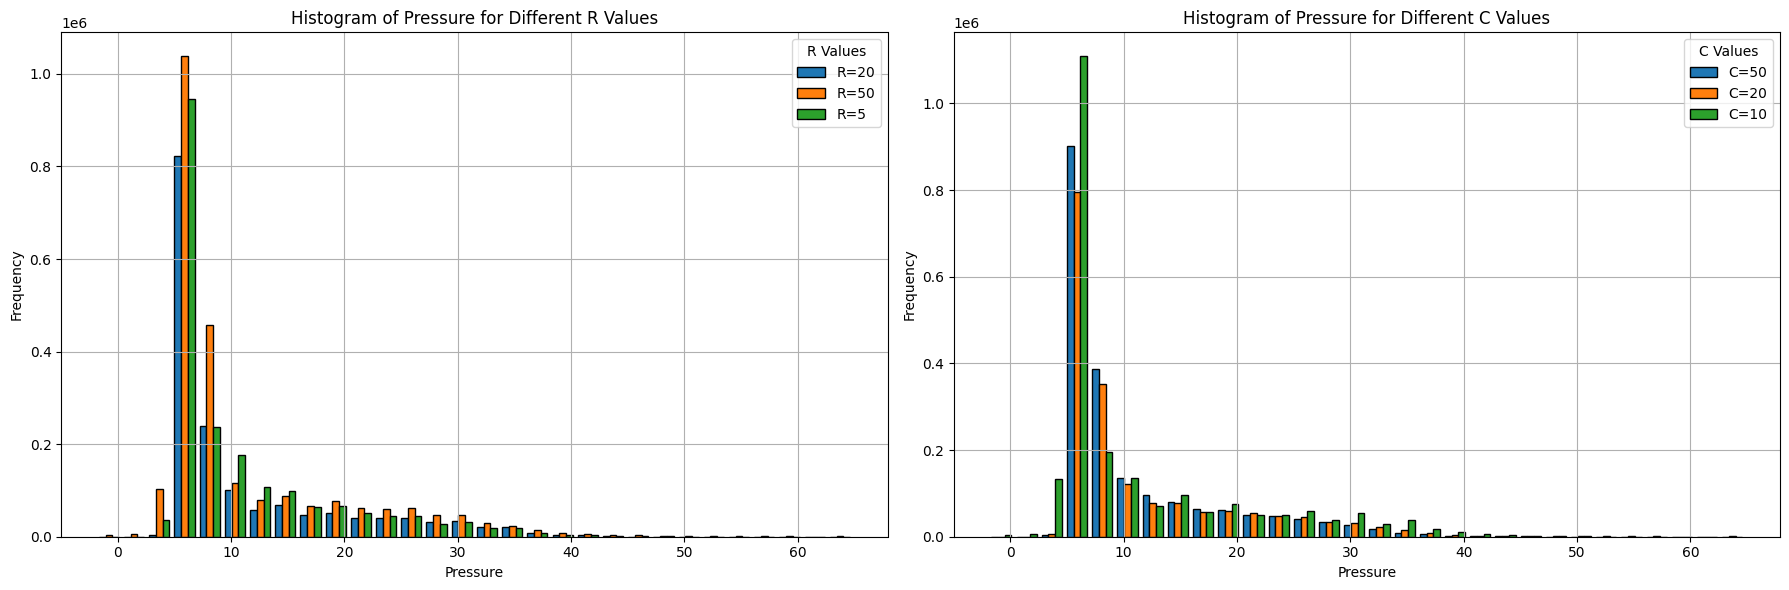

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="pressure-histograms-R-C")

# Create subplots for the graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram showing the distribution of Pressure for different R values
axes[0].hist(
    [df_train[df_train['R'] == r]['pressure'] for r in df_train['R'].unique()],
    bins=30,
    label=[f'R={r}' for r in df_train['R'].unique()],
    edgecolor='black'
)
axes[0].set_title('Histogram of Pressure for Different R Values')
axes[0].set_xlabel('Pressure')
axes[0].set_ylabel('Frequency')
axes[0].legend(title="R Values")
axes[0].grid(True)

# Histogram showing the distribution of Pressure for different C values
axes[1].hist(
    [df_train[df_train['C'] == c]['pressure'] for c in df_train['C'].unique()],
    bins=30,
    label=[f'C={c}' for c in df_train['C'].unique()],
    edgecolor='black'
)
axes[1].set_title('Histogram of Pressure for Different C Values')
axes[1].set_xlabel('Pressure')
axes[1].set_ylabel('Frequency')
axes[1].legend(title="C Values")
axes[1].grid(True)

plt.tight_layout()

# ✅ Log to WandB before plt.show()
wandb.log({"Pressure Distribution by R and C": wandb.Image(fig)})

# ✅ Display in Colab
plt.show()

# ✅ Close the figure
plt.close()

wandb.finish()


**Does the resistance (R) or compliance (C) setting affect the pressure distribution?**

If pressure behaves differently for different R or C, it means:
  * R and C are important features.
  * The model should be trained to learn their effect.

### Feature vs. Pressure Plots for Training Set

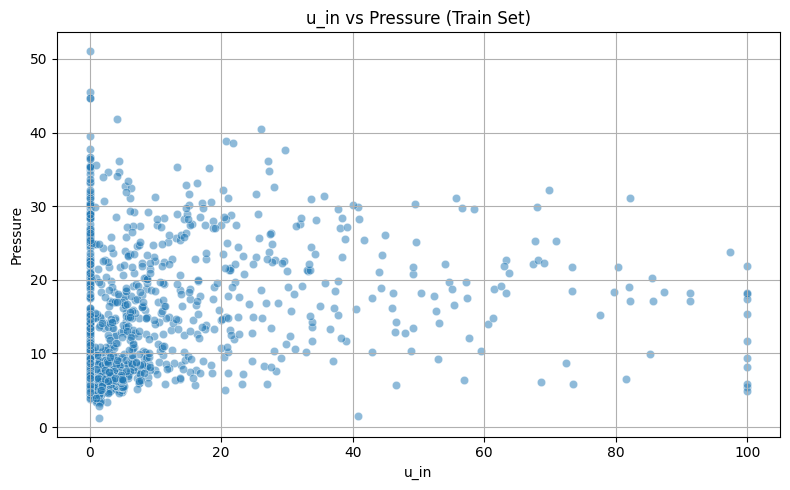

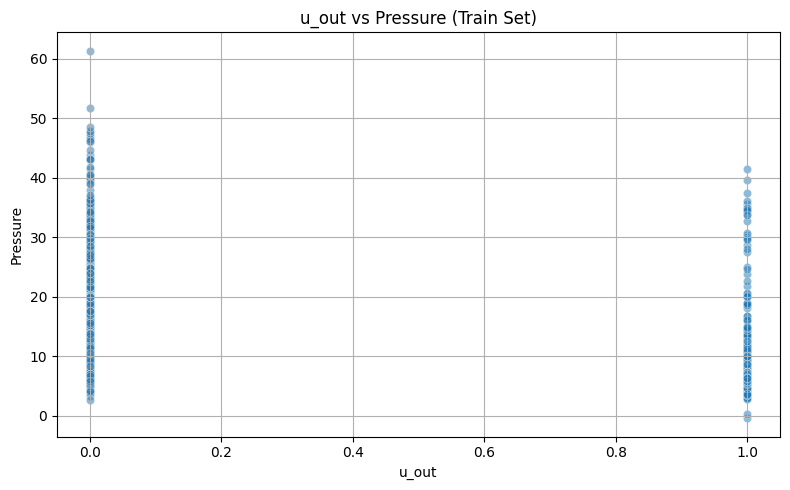

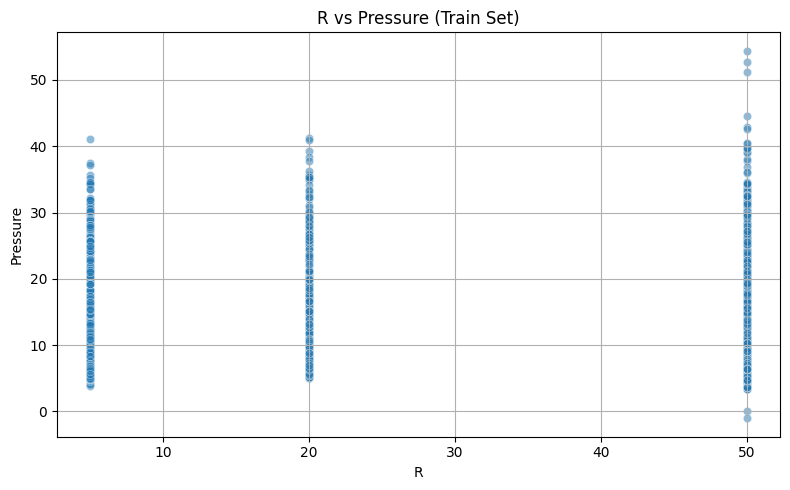

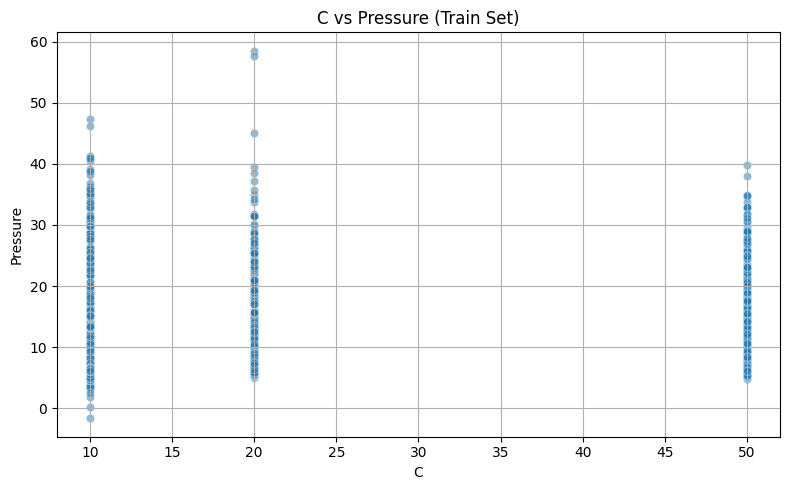

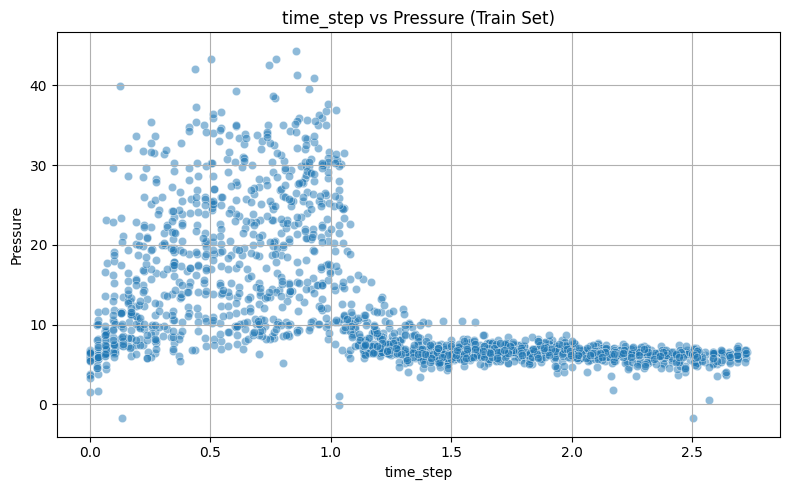

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="feature-vs-pressure-train")

# Features to compare with pressure
features_to_plot = ['u_in', 'u_out', 'R', 'C', 'time_step']

# Loop through each feature in df_train
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_train.sample(2000), x=feature, y='pressure', alpha=0.5)
    plt.title(f"{feature} vs Pressure (Train Set)")
    plt.xlabel(feature)
    plt.ylabel("Pressure")
    plt.grid(True)
    plt.tight_layout()

    # ✅ Log to WandB before plt.show()
    wandb.log({f"Train_{feature}_vs_Pressure": wandb.Image(plt.gcf())})

    # ✅ Display in Colab
    plt.show()

    # ✅ Close the figure
    plt.close()

# Finish WandB run
wandb.finish()


### Feature Distributions (df_train and df_test)

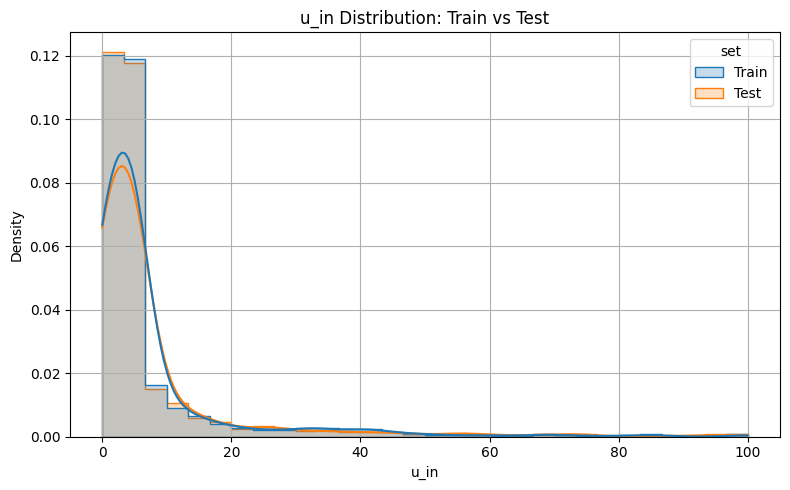

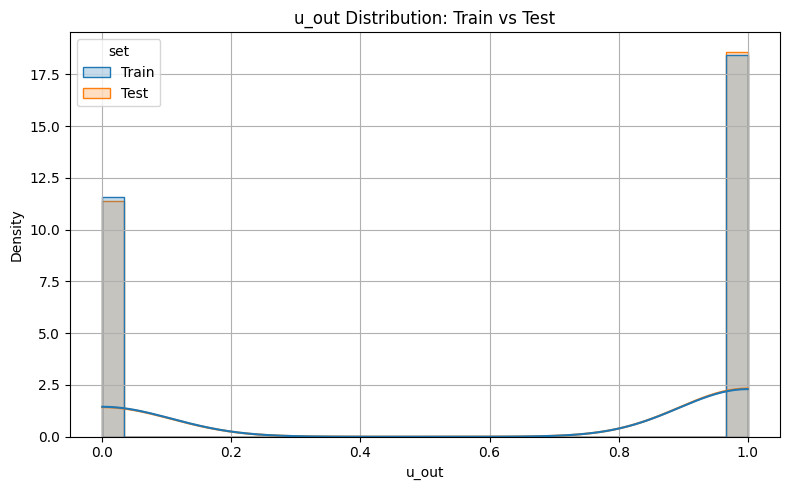

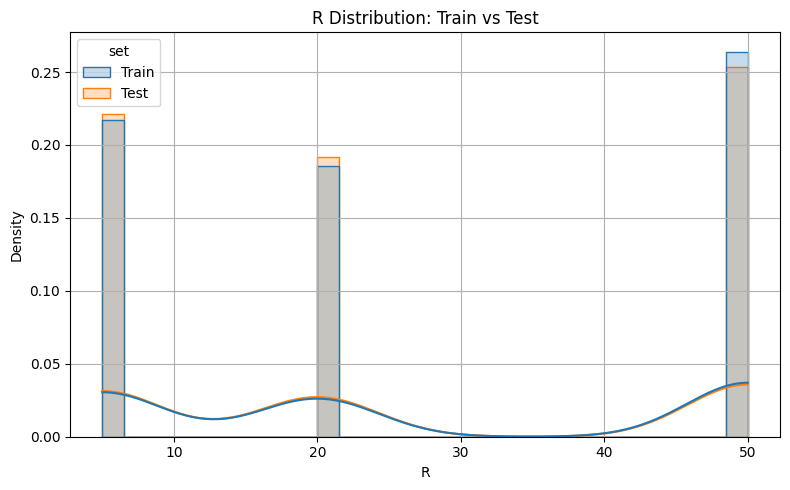

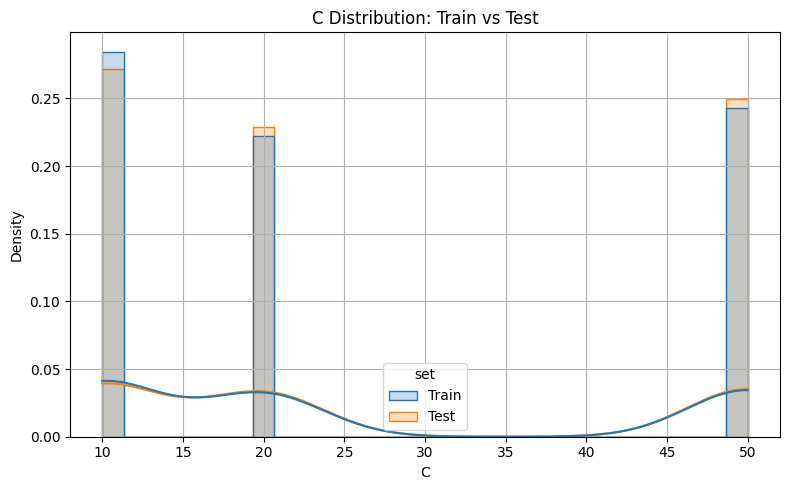

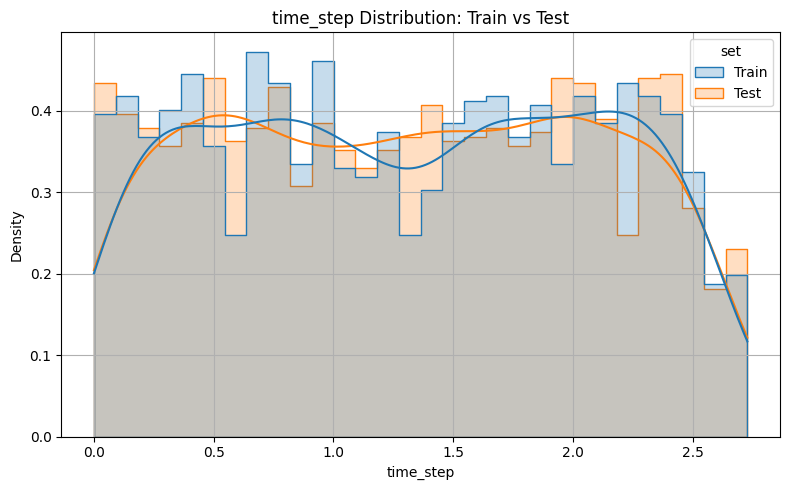

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="feature-distributions-train-test")

# Features to visualize
features_to_plot = ['u_in', 'u_out', 'R', 'C', 'time_step']

# Loop by feature
for feature in features_to_plot:
    # Sample from each dataset to keep it efficient
    train_sample = df_train[[feature]].sample(2000, random_state=42).copy()
    test_sample = df_test[[feature]].sample(2000, random_state=42).copy()

    train_sample['set'] = 'Train'
    test_sample['set'] = 'Test'

    combined = pd.concat([train_sample, test_sample], axis=0)

    # Plot combined distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data=combined, x=feature, hue='set', kde=True, bins=30, element="step", stat="density", common_norm=False)

    plt.title(f"{feature} Distribution: Train vs Test")
    plt.xlabel(feature)
    plt.grid(True)
    plt.tight_layout()

    # ✅ Log to WandB
    wandb.log({f"{feature}_Train_vs_Test_Distribution": wandb.Image(plt.gcf())})

    # ✅ Show in Colab
    plt.show()

    # ✅ Close plot
    plt.close()

# Finish WandB run
wandb.finish()


The dataset has a good distribution. So we don't need to manipulate the data further, as it is already well-balanced for analysis.

### Temporal Pressure + Feature Overlay for Sample Breaths

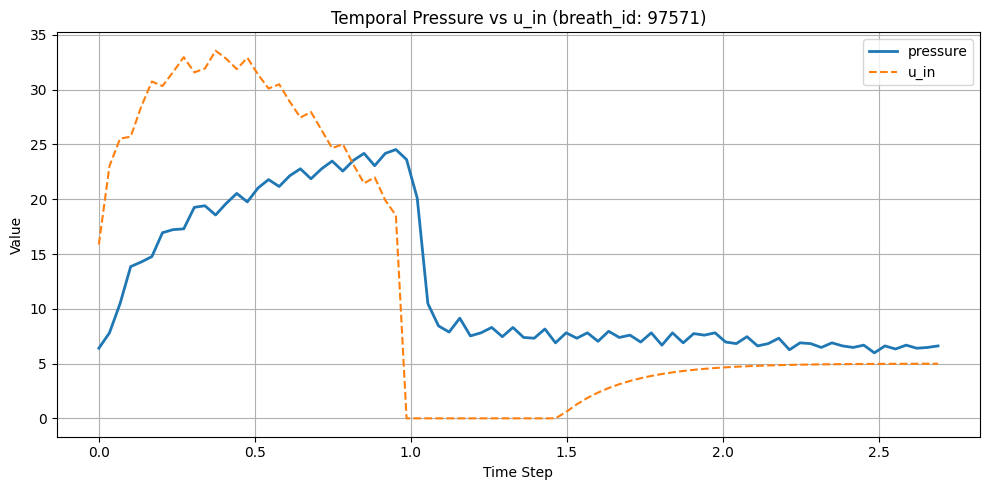

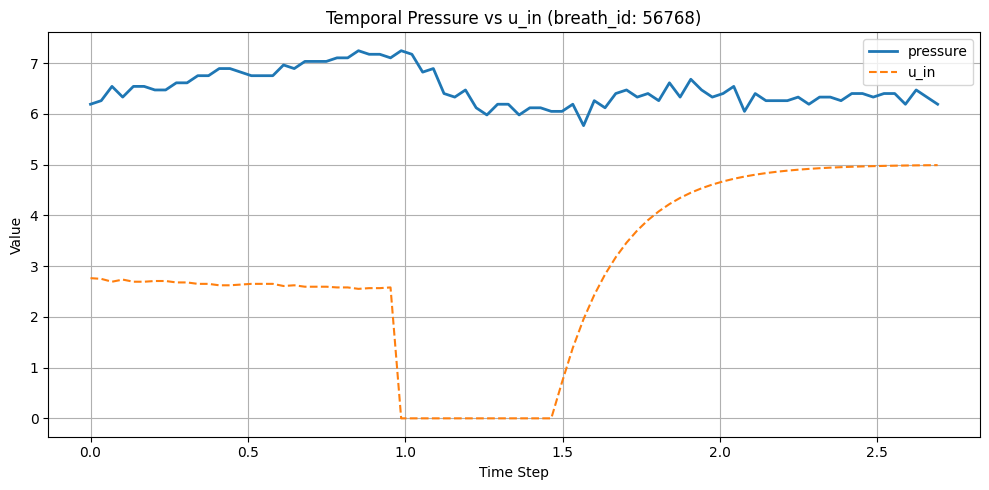

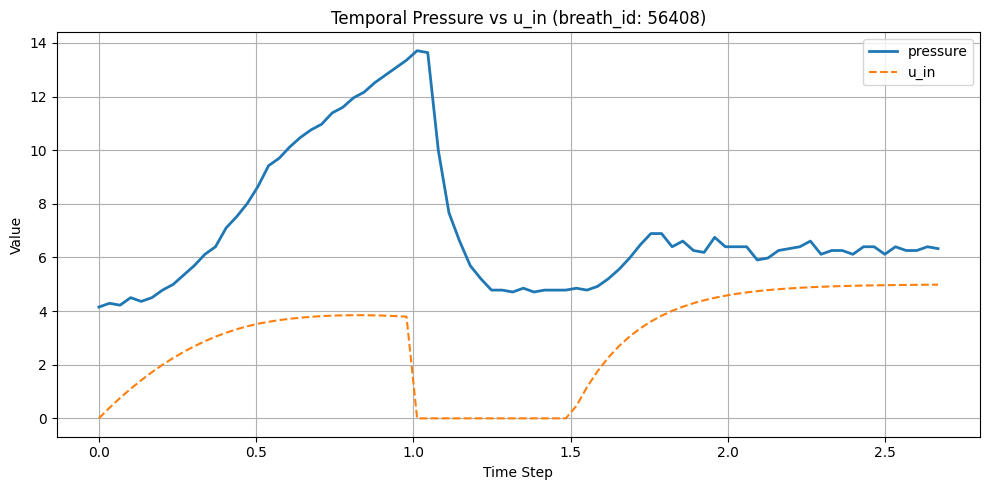

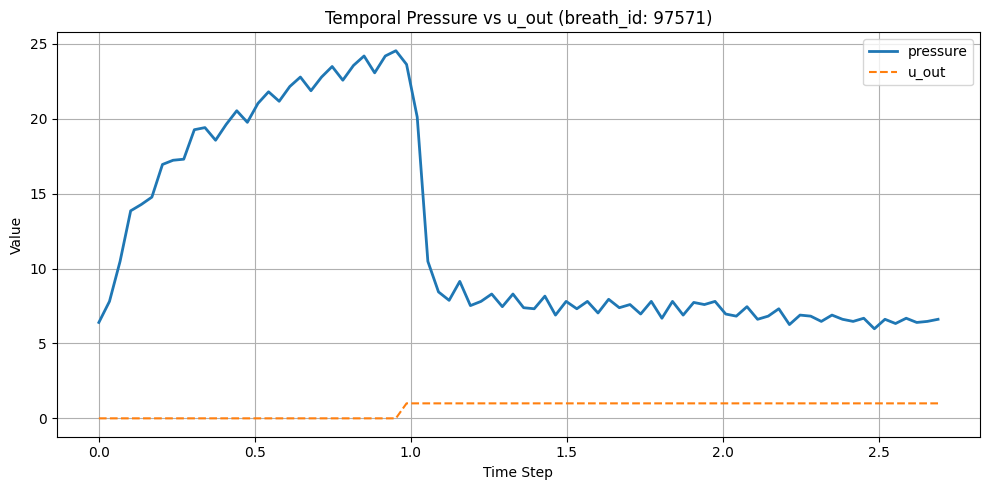

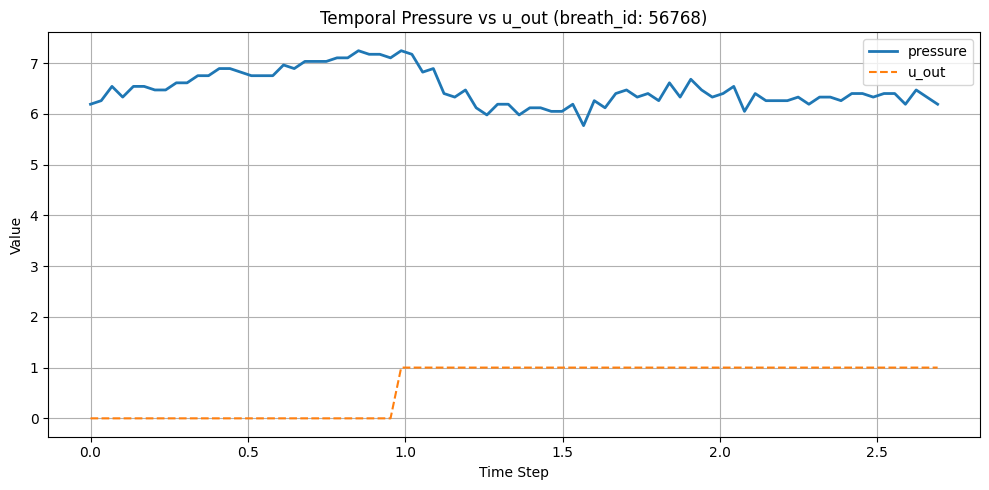

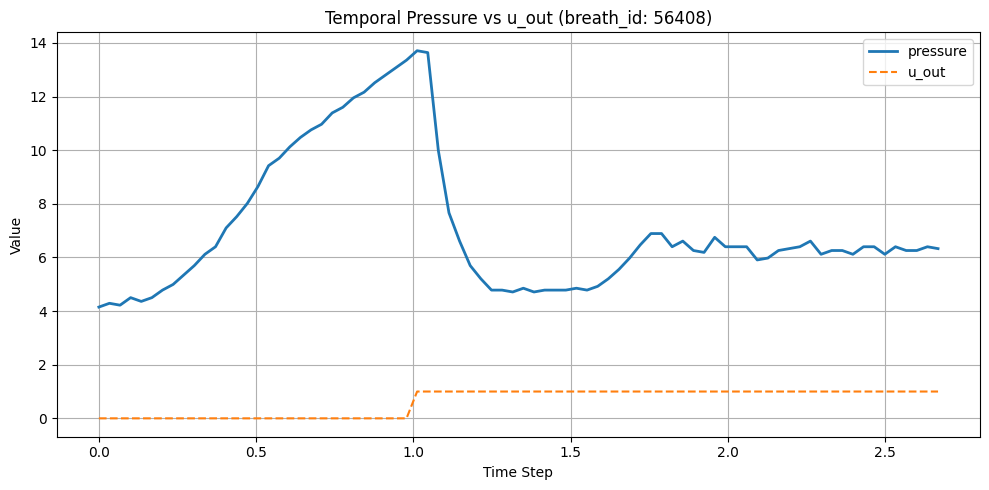

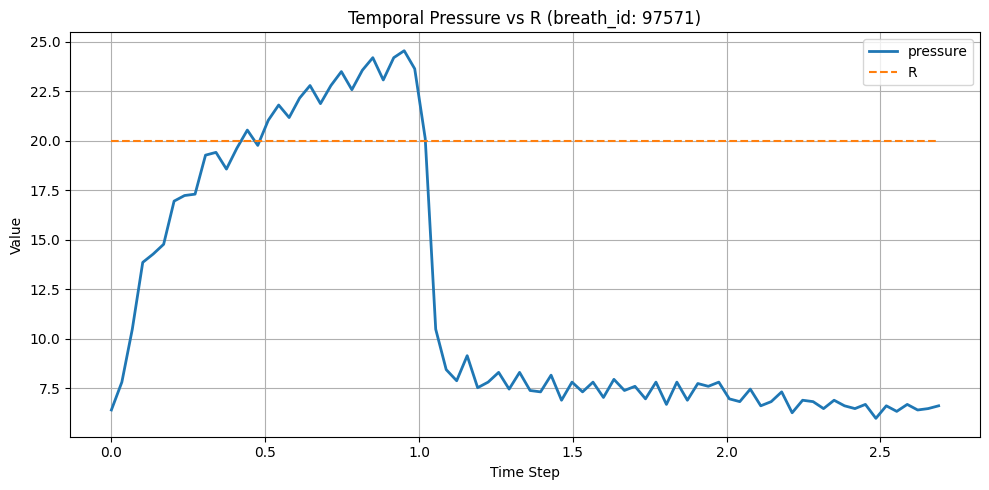

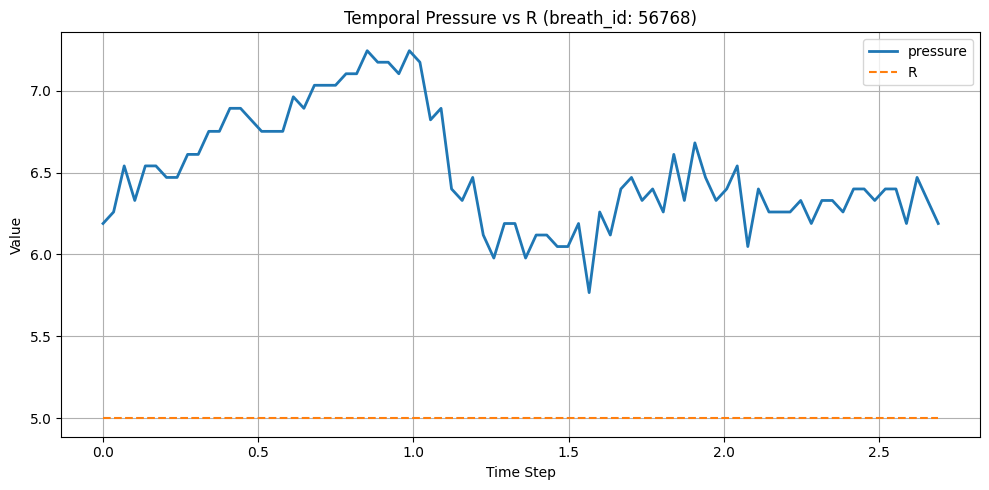

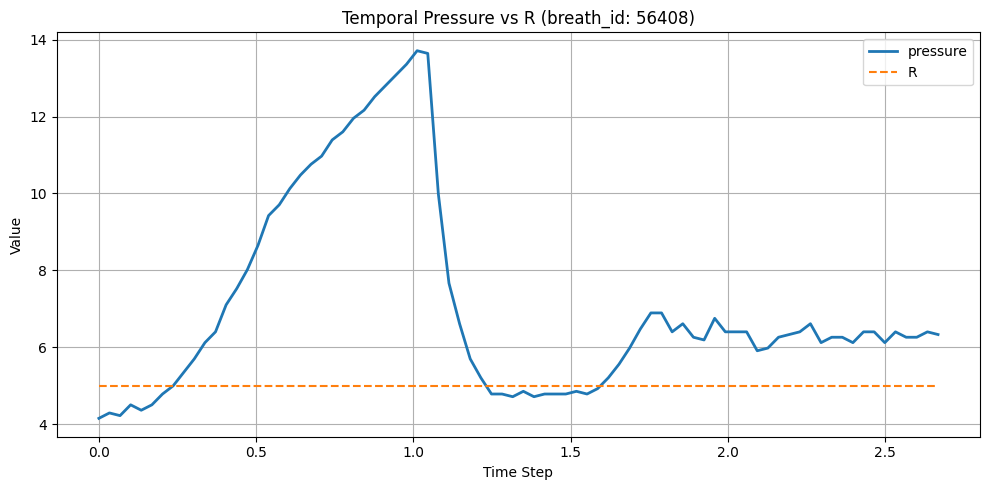

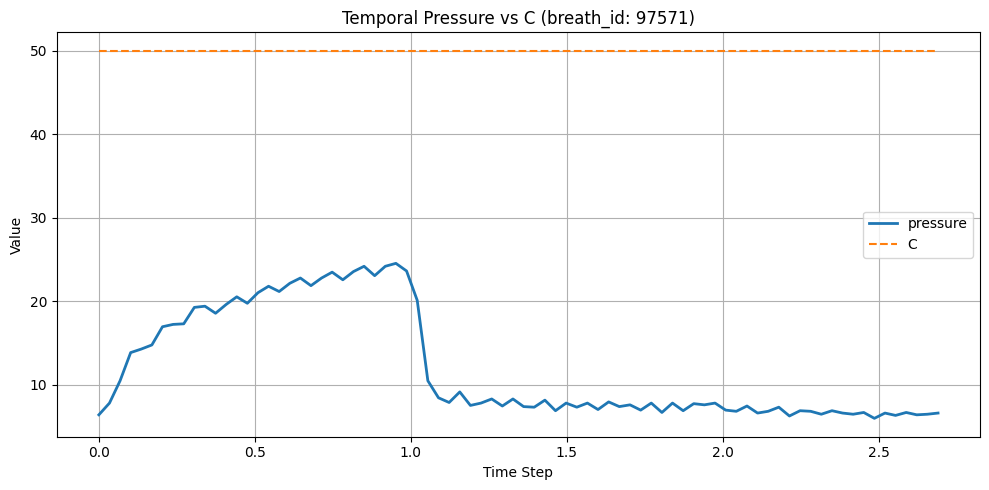

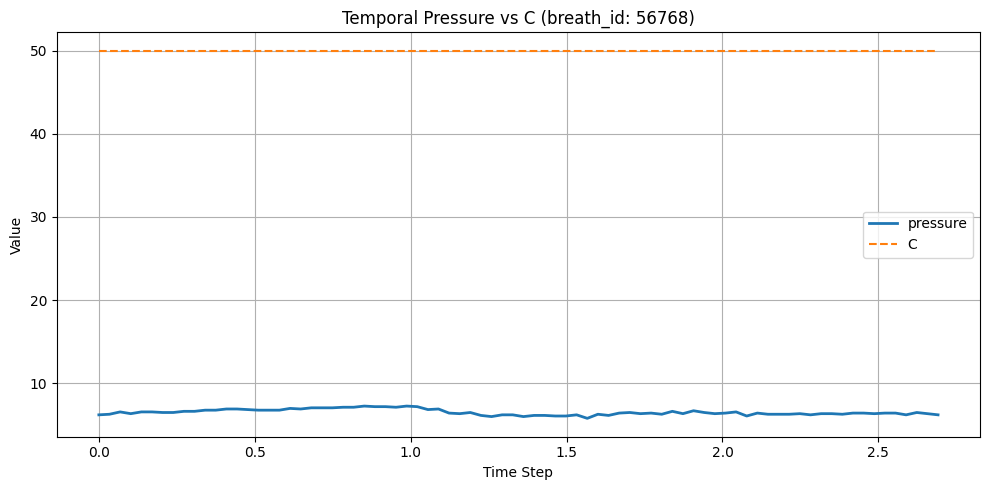

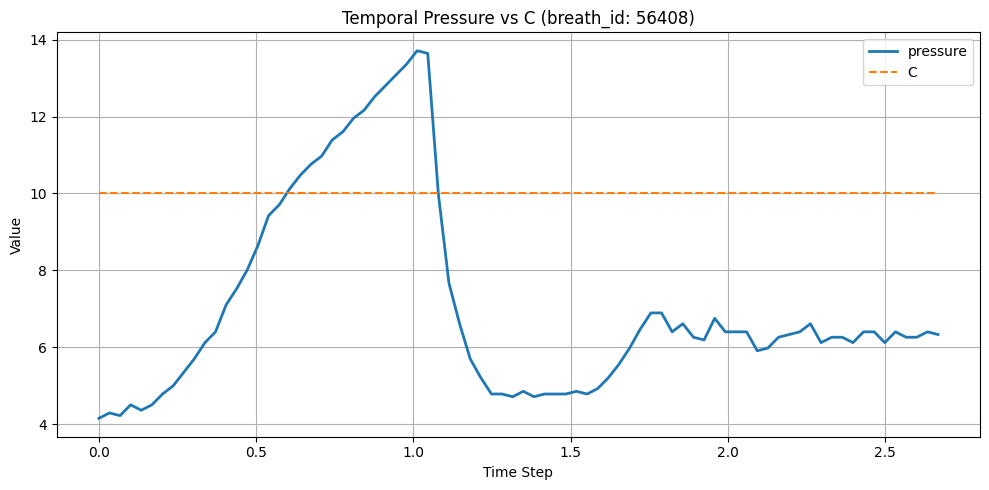

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="temporal-pressure-feature-analysis")

# Features to compare with pressure
features_to_compare = ['u_in', 'u_out', 'R', 'C']

# Pick a few random breath_ids
sample_breath_ids = df_train['breath_id'].drop_duplicates().sample(3, random_state=42).values

# For each feature and each sample breath
for feature in features_to_compare:
    for breath_id in sample_breath_ids:
        breath = df_train[df_train['breath_id'] == breath_id]

        plt.figure(figsize=(10, 5))
        plt.plot(breath['time_step'], breath['pressure'], label='pressure', linewidth=2)
        plt.plot(breath['time_step'], breath[feature], label=feature, linestyle='--')
        plt.title(f"Temporal Pressure vs {feature} (breath_id: {breath_id})")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # ✅ Log to WandB
        wandb.log({f"Pressure_vs_{feature}_Breath_{breath_id}": wandb.Image(plt.gcf())})

        # ✅ Show in Colab
        plt.show()

        # ✅ Close to avoid overlap
        plt.close()

# Finish WandB run
wandb.finish()


### Pairplot

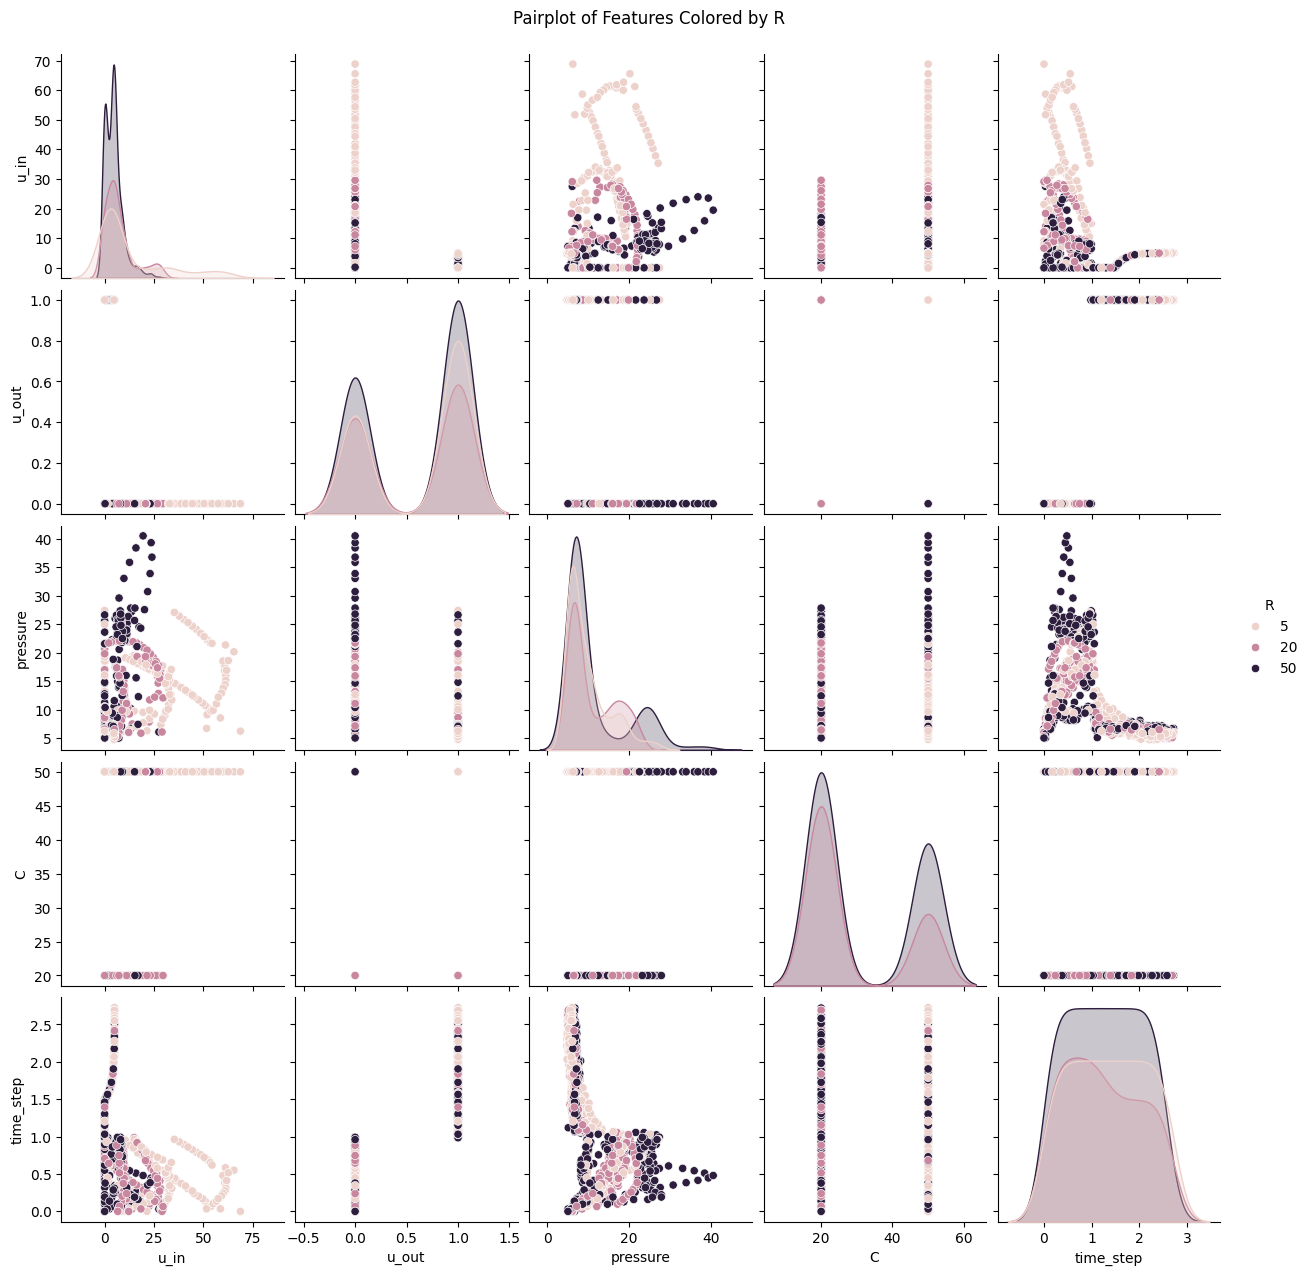

In [ ]:
# Sample a smaller subset for readability
pairplot_sample = df_train.sample(1000, random_state=42)

# Select only relevant numeric columns
columns_to_plot = ['u_in', 'u_out', 'pressure', 'R', 'C', 'time_step']

# Create the pairplot
sns_plot = sns.pairplot(pairplot_sample[columns_to_plot], hue="R", height=2.5)

# Save to WandB and show
sns_plot.fig.suptitle("Pairplot of Features Colored by R", y=1.02)

# Log to WandB
wandb.init(project="DS50_ventilator-pressure-prediction", name="pairplot-analysis")
wandb.log({"Pairplot R hue": wandb.Image(sns_plot.fig)})
plt.show()
wandb.finish()


### Visualizing 3 breaths

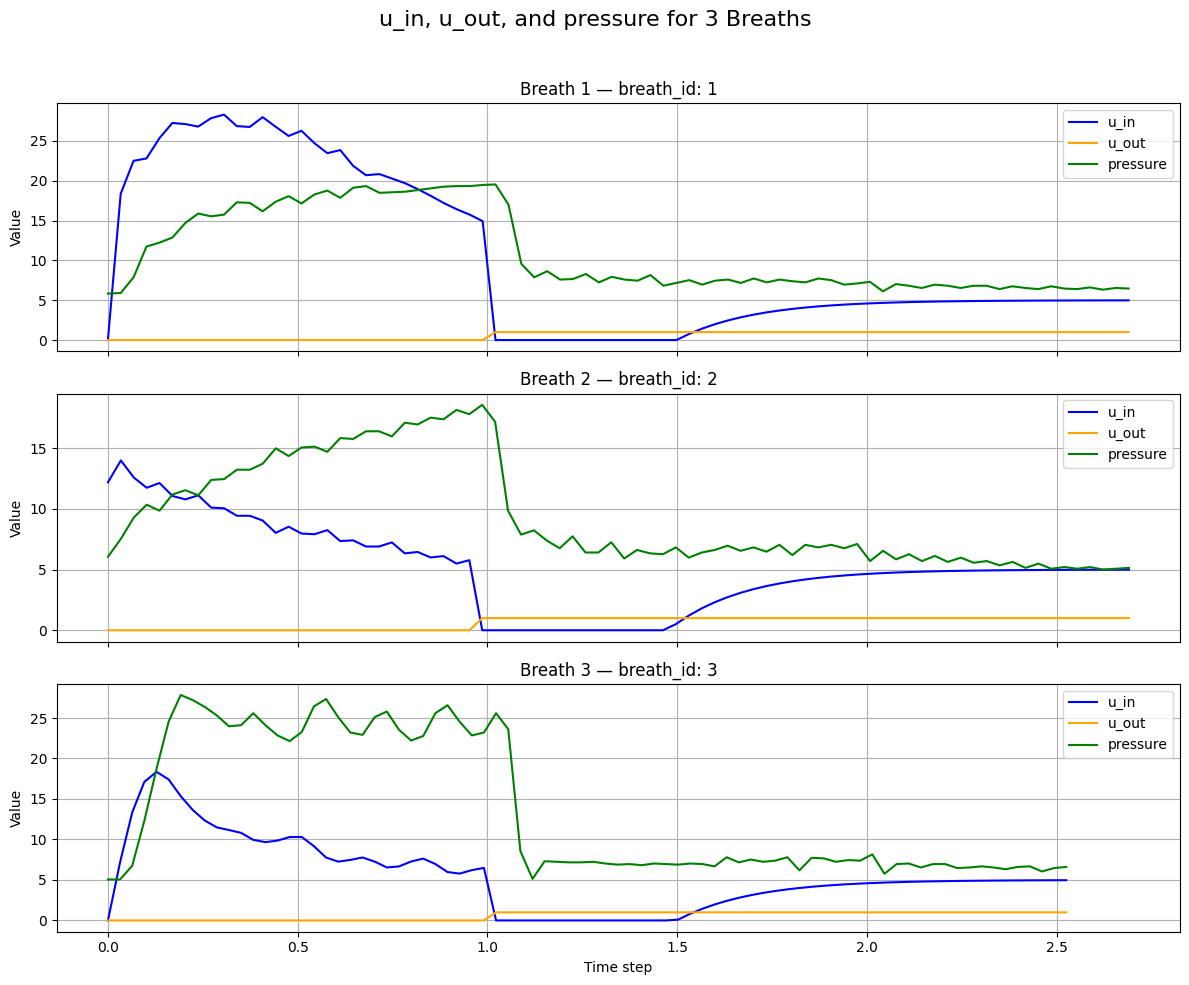

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="u_in-u_out-pressure-different-breaths")

# Load the dataset
df = df_train
# Select the first 3 full breaths (each with 80 time steps)
breath_ids = df['breath_id'].unique()[:3]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, breath_id in enumerate(breath_ids):
    breath = df[df['breath_id'] == breath_id]

    axs[i].plot(breath['time_step'], breath['u_in'], label='u_in', color='blue')
    axs[i].plot(breath['time_step'], breath['u_out'], label='u_out', color='orange')
    axs[i].plot(breath['time_step'], breath['pressure'], label='pressure', color='green')

    axs[i].set_title(f"Breath {i+1} — breath_id: {breath_id}")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time step")
plt.suptitle("u_in, u_out, and pressure for 3 Breaths", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

wandb.log({"u_in, u_out, and pressure for 3 Breaths": wandb.Image(plt.gcf())})
plt.show()
wandb.finish()


Observation:

Despite the structure of each breath being similar (same number of time steps and similar phases), differences in pressure behavior are explained by:

The ventilator input signal (u_in) pattern

The lung mechanics (R, C) assigned per breath

The release of air (u_out) triggering a pressure drop

Understanding these patterns is critical for designing a model that can accurately learn and predict ventilator pressure across a variety of lung conditions.

### TSNE for Dimensionality Reduction

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


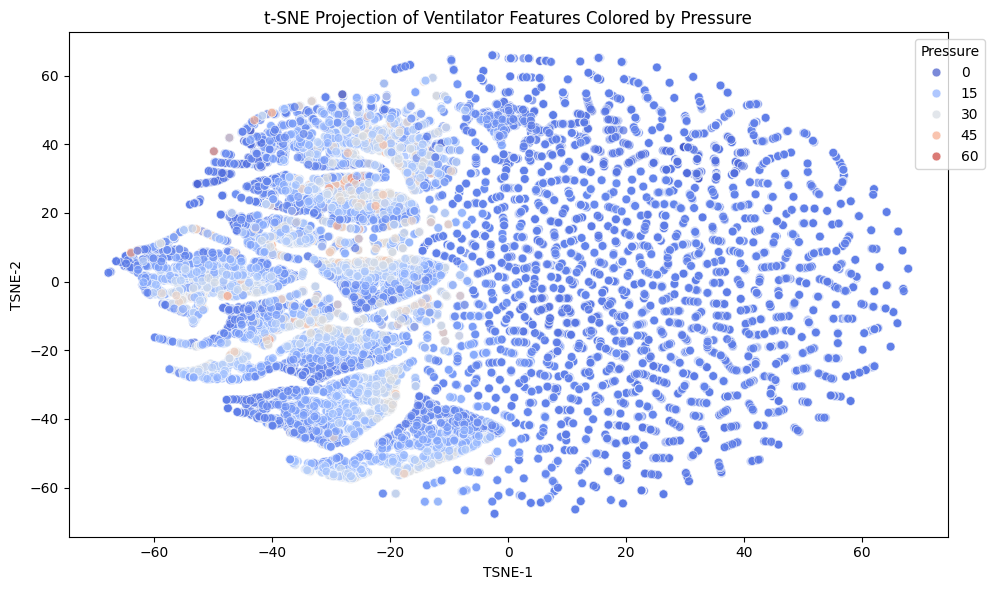

In [ ]:
# Start new WandB run
wandb.init(project="DS50_ventilator-pressure-prediction", name="tsne-visualization")

# 1. Select relevant numeric features
features = ['u_in', 'u_out', 'R', 'C', 'time_step']
df_tsne = df_train[features + ['pressure']].dropna().copy()

# 2. Sample for performance
df_train_tsne = pd.read_csv('train.csv', index_col = 'id')
df_tsne = df_train.sample(n=50000, random_state=42)
# df_tsne = pd.read_csv('train.csv', index_col = 'id')

# 3. Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_tsne[features])

# 4. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, learning_rate='auto', init='pca', random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

# 5. Add t-SNE results back to DataFrame
df_tsne['TSNE-1'] = tsne_result[:, 0]
df_tsne['TSNE-2'] = tsne_result[:, 1]

# 6. Plot with pressure as color
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='TSNE-1', y='TSNE-2', hue='pressure', palette='coolwarm', s=40, alpha=0.7)
plt.title("t-SNE Projection of Ventilator Features Colored by Pressure")
plt.legend(title="Pressure", loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# 7. Log to WandB
wandb.log({"t-SNE Scatterplot": wandb.Image(plt.gcf())})
plt.show()
wandb.finish()


What Are We Looking At?
* This is a 2D t-SNE projection of our ventilator dataset.
* Each dot = one time step (row in df_train)
* The dot’s position reflects how similar its input features are to others (based on u_in, u_out, R, C, time_step)
* The color shows the pressure value — from blue (low) to red (high)

t-SNE reduces 5D data (5 input features) to 2D — so we can visualize are there clusters or separations based on the input features?
Do similar input conditions lead to similar pressure outputs?
Is the structure of the data meaningful enough to be learned by a model?

**Clusters or tight blobs**
 : These represent groups of data rows (time steps) that share similar input conditions and produce similar pressure values. For example
A cluster may include time steps where: u_in is high, u_out = 0, R = 5, C = 50

Early in the breath cycle (low time_step). These conditions produce a consistent pressure pattern, so they are grouped together.


*In this t-SNE plot, TSNE-1 and TSNE-2 are synthetic axes that show how similar input conditions cluster in high-dimensional space.
We see that time steps with similar ventilator settings — such as high u_in, low u_out, and specific lung parameters — are grouped into dense clusters or form curved structures.
These patterns reflect the repetitive nature of breathing cycles.
Some line-shaped structures likely represent time-evolving sequences within breaths.
We used 50,000 randomly sampled points to make computation efficient while still preserving meaningful insights.*


### Correlation Matrix

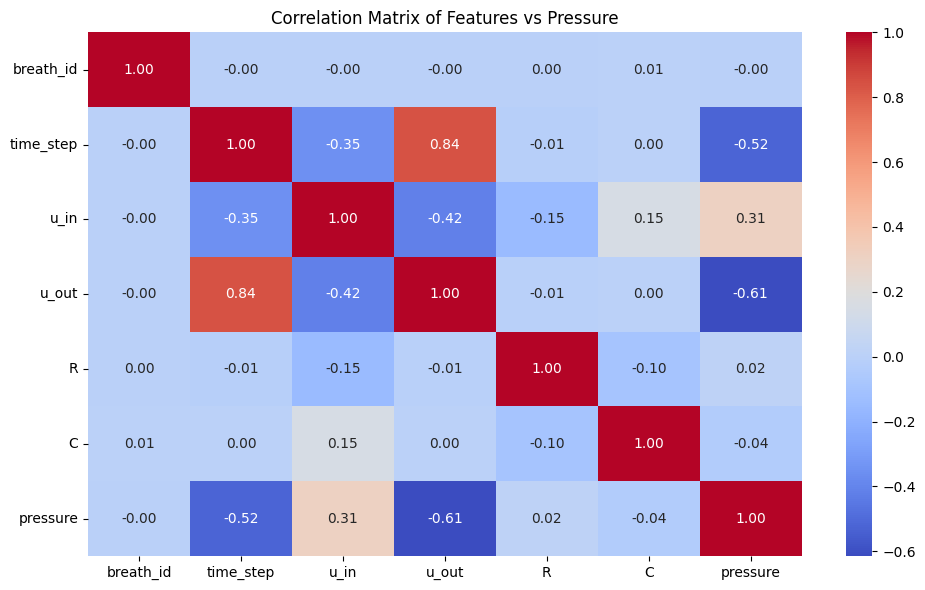

In [ ]:
wandb.init(project="DS50_ventilator-pressure-prediction", name="correlation-matrix")

# Only use numeric columns for correlation
corr_matrix = df_train[['breath_id', 'time_step', 'u_in', 'u_out', 'R', 'C', 'pressure']].corr()

# Create the heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features vs Pressure")
plt.tight_layout()

# ✅ Log to WandB before showing
wandb.log({"Correlation Matrix": wandb.Image(plt.gcf())})

# ✅ Display in Colab
plt.show()

# ✅ Finish WandB run
wandb.finish()

* u_out and pressure:
There is a strong negative correlation of -0.61, indicating that when u_out = 1 (i.e., the valve opens), pressure tends to drop.
This matches domain knowledge — pressure builds while the valve is closed, and drops when it opens.

* time_step and pressure:
Shows a moderate negative correlation of -0.52, suggesting that as time progresses within a breath, pressure tends to decrease.
This reflects the pressure release toward the end of the breathing cycle.

* u_in and pressure:
Has a positive correlation of 0.31, meaning higher air intake (u_in) generally corresponds to higher pressure — a direct and expected physical relationship.

* time_step and u_out:
Very strong positive correlation (0.84) — indicating that u_out is more likely to be 1 (open) later in the breath cycle.
This again makes sense: the ventilator opens the valve near the end of each breath.

* u_in and u_out:
Correlation of -0.42 — they typically move in opposite directions. As air is pushed in (u_in increases), the valve is usually closed (u_out = 0), and it opens (u_out = 1) when u_in returns to 0.

* R and C vs. pressure:
Show very weak correlations (0.02 and -0.04 respectively). This suggests that although R and C define the mechanical characteristics of the lung, they may not directly correlate linearly with pressure at each time step — but they likely impact the overall shape of the breathing curve, which deep learning models may still capture.

*This matrix confirms that u_in, u_out, and time_step are the most influential features in pressure prediction.
These findings guide us in feature engineering and model focus. Understanding the opposite roles of u_in and u_out, as well as the timing pattern in time_step, is key to designing effective sequence-based models like GRU or LSTM.*

## 3.0 Model : Paper’s Baseline

In [7]:
data_sample = df_train.sample(frac=0.01, random_state=42)

In [8]:
data_sample.shape

(60360, 7)

In [9]:
X = data_sample.drop(columns=['pressure']).values
y = data_sample['pressure'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
from sklearn.preprocessing import MinMaxScaler
import wandb

# Start wandb run
wandb.init(project="DS50_ventilator-pressure-prediction", name="scaling-features")

# Define features
features = ['R', 'C', 'time_step', 'u_in', 'u_out']
scaler = MinMaxScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])

# Scale target separately
scaler_pressure = MinMaxScaler()
df_train['pressure'] = scaler_pressure.fit_transform(df_train[['pressure']])

# Log feature ranges
for feature in features:
    wandb.log({
        f"{feature} (min)": df_train[feature].min(),
        f"{feature} (max)": df_train[feature].max(),
        f"{feature} (mean)": df_train[feature].mean()
    })

wandb.finish()


c:\Users\User\anaconda3\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


C (max),▁
C (mean),▁
C (min),▁
R (max),▁
R (mean),▁
R (min),▁
time_step (max),▁
time_step (mean),▁
time_step (min),▁
u_in (max),▁
u_in (mean),▁


### 3.1 Sequence Creation

In [12]:
import numpy as np

def create_dataset(df, time_step=30):
    X, y = [], []
    values = df[features + ['pressure']].values
    for i in range(len(values) - time_step):
        X.append(values[i:i + time_step, :-1])
        y.append(values[i + time_step, -1])
    return np.array(X), np.array(y)

X, y = create_dataset(df_train, time_step=30)


### 3.2 Split Data + wandb Logging

In [13]:
from sklearn.model_selection import train_test_split

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

wandb.init(project="DS50_ventilator-pressure-prediction", name="data-splits")
wandb.log({
    "X_train shape": X_train.shape[0],
    "X_val shape": X_val.shape[0],
    "X_test shape": X_test.shape[0],
    "Time Steps": X_train.shape[1],
    "Num Features": X_train.shape[2]
})
wandb.finish()


c:\Users\User\anaconda3\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Num Features,▁
Time Steps,▁
X_test shape,▁
X_train shape,▁
X_val shape,▁
Num Features,5
Time Steps,30
X_test shape,603597
X_train shape,4828776
X_val shape,603597


### 3.3 PyTorch Dataset + DataLoader


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class PressureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(PressureDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(PressureDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(PressureDataset(X_test, y_test), batch_size=batch_size)


#### 3.3.1 GRU Model

In [15]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n.squeeze(0))


### 3.4 Training & Validation Loops with WandB Logging

In [17]:
def train_model(model, train_loader, val_loader, epochs, name):
    wandb.init(project="DS50_ventilator-pressure-prediction", name=name)
    wandb.watch(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_loss += loss_fn(model(X_batch), y_batch).item()

        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss / len(train_loader),
            "val_loss": val_loss / len(val_loader)
        })

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.5f}, Val Loss={val_loss:.5f}")

    wandb.finish()
    return model


In [18]:
input_dim = X_train.shape[2]
model = GRUModel(input_dim=input_dim, hidden_dim=150)
trained_model = train_model(model, train_loader, val_loader, epochs=10, name="GRU")


Epoch 1: Train Loss=30.92267, Val Loss=2.47049
Epoch 2: Train Loss=17.85021, Val Loss=2.07716
Epoch 3: Train Loss=15.10613, Val Loss=2.14307
Epoch 4: Train Loss=13.65269, Val Loss=1.77670
Epoch 5: Train Loss=12.75977, Val Loss=1.62914
Epoch 6: Train Loss=12.08781, Val Loss=1.63046
Epoch 7: Train Loss=11.60456, Val Loss=1.58582
Epoch 8: Train Loss=11.44250, Val Loss=1.48227
Epoch 9: Train Loss=167.34605, Val Loss=32.52935
Epoch 10: Train Loss=299.65319, Val Loss=35.70250


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,▁▁▁▁▁▁▁▁▅█
val_loss,▁▁▁▁▁▁▁▁▇█
epoch,10
train_loss,0.00397
val_loss,0.00379


## 4.0 Model : Prediction on Unseen Dataset

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, test_loader, scaler_pressure, name="GRU"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preds = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            preds.extend(outputs)
            actuals.extend(y_batch.numpy())

    # Inverse transform pressure
    preds_inv = scaler_pressure.inverse_transform(np.array(preds))
    actuals_inv = scaler_pressure.inverse_transform(np.array(actuals))

    # Calculate metrics
    mse = mean_squared_error(actuals_inv, preds_inv)
    mae = mean_absolute_error(actuals_inv, preds_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals_inv, preds_inv)

    # wandb logging
    wandb.init(project="DS50_ventilator-pressure-prediction", name=f"eval-{name}")
    wandb.log({
        f"{name}_MSE": mse,
        f"{name}_MAE": mae,
        f"{name}_RMSE": rmse,
        f"{name}_R2": r2,
    })

    # Log a few predictions
    pred_table = pd.DataFrame({
        "Actual": actuals_inv.flatten(),
        "Predicted": preds_inv.flatten()
    }).sample(100)

    wandb.log({f"{name}_Predictions": wandb.Table(dataframe=pred_table)})

    # Plot predictions vs actual
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(actuals_inv[:200], label="Actual", linewidth=2)
    plt.plot(preds_inv[:200], label="Predicted", linewidth=2)
    plt.title(f"{name} Predictions vs Actual")
    plt.xlabel("Sample")
    plt.ylabel("Pressure")
    plt.legend()
    wandb.log({f"{name}_Plot": wandb.Image(plt)})
    wandb.finish()

    return mse, mae, rmse, r2


c:\Users\User\anaconda3\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


GRU_MAE,▁
GRU_MSE,▁
GRU_R2,▁
GRU_RMSE,▁
GRU_MAE,2.49734
GRU_MSE,16.5694
GRU_R2,0.74645
GRU_RMSE,4.07055


MAE: 2.4973, RMSE: 4.0706, R²: 0.7465


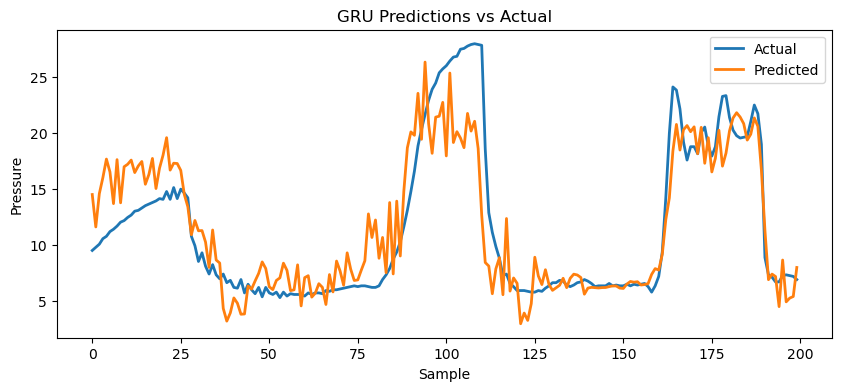

In [20]:
mse, mae, rmse, r2 = evaluate_model(trained_model, test_loader, scaler_pressure, name="GRU")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


## 4.0 Model : Prediction on Test Dataset

In [21]:
df_test_scaled = df_test.copy()
df_test_scaled[features] = scaler.transform(df_test[features])  # same scaler as before

In [22]:
def create_test_sequences(df_test_scaled, time_step=30):
    X_test_final = []
    values = df_test_scaled[features].values
    for i in range(len(values) - time_step):
        X_test_final.append(values[i:i + time_step])
    return np.array(X_test_final)

X_test_final = create_test_sequences(df_test_scaled)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
preds = []

with torch.no_grad():
    for i in range(0, len(X_test_final), batch_size):
        X_batch = torch.tensor(X_test_final[i:i+batch_size], dtype=torch.float32).to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)

preds_inv = scaler_pressure.inverse_transform(np.array(preds))


In [38]:
import pandas as pd
import numpy as np

# Load submission
submission = pd.read_csv("sample_submission.csv")

# Fix prediction length mismatch
pad_size = len(submission) - len(preds_inv)
pad_values = np.full((pad_size, 1), preds_inv[0])  # Pad with first predicted value

# Concatenate padding + actual predictions
full_preds = np.vstack([pad_values, preds_inv])

# Assign to submission
submission["pressure"] = full_preds.flatten()
submission.to_csv("my_submission.csv", index=False)

print("✅ Final submission saved with shape:", submission.shape)


✅ Final submission saved with shape: (4024000, 2)


In [36]:
df_test.shape

(4024000, 6)

In [ ]:
import wandb
import matplotlib.pyplot as plt

# Start a wandb run for logging predictions
wandb.init(project="DS50_ventilator-pressure-prediction", name="test-set-prediction")

# Log preview table
wandb.log({
    "Test Predictions Table": wandb.Table(dataframe=submission.head(100))
})

# Optional: plot first 300 predictions
plt.figure(figsize=(12, 4))
plt.plot(submission["pressure"][:300], label="Predicted Pressure")
plt.title("Predicted Pressure on df_test")
plt.xlabel("Row Index")
plt.ylabel("Pressure")
plt.legend()
plt.grid(True)
wandb.log({"Test Prediction Plot": wandb.Image(plt)})

# Log full submission file as artifact
artifact = wandb.Artifact("test_predictions", type="prediction")
artifact.add_file("my_submission.csv")
wandb.log_artifact(artifact)

wandb.finish()


# Deep Learning Architectures

# Supervised deep learning

Supervised learning refers to the problem space wherein the target to be predicted is clearly labelled within the data that is used for training.

In this section, we introduce at a high-level two of the most popular supervised deep learning architectures - convolutional neural networks and recurrent neural networks as well as some of their variants.

#Convolutional neural networks

A CNN is a multilayer neural network that was biologically inspired by the animal visual cortex. The architecture is particularly useful in image-processing applications. The first CNN was created by Yann LeCun; at the time, the architecture focused on handwritten character recognition, such as postal code interpretation. As a deep network, early layers recognize features (such as edges), and later layers recombine these features into higher-level attributes of the input.

The LeNet CNN architecture is made up of several layers that implement feature extraction and then classification (see the following image). The image is divided into receptive fields that feed into a convolutional layer, which then extracts features from the input image. The next step is pooling, which reduces the dimensionality of the extracted features (through down-sampling) while retaining the most important information (typically, through max pooling). Another convolution and pooling step is then performed that feeds into a fully connected multilayer perceptron. The final output layer of this network is a set of nodes that identify features of the image (in this case, a node per identified number). You train the network by using back-propagation.

![alt text here](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiKxCI58GxJCPeV0KRFjHHCcNNNq1iETXU8s1ddNTfKFgbDMtw3uYfbwYvVxlgwtx8z7N1CSfHUn2c-y7n6jTn6dIDNnuXwhiyDSa_7gnv3-IJ4hoMi9IJ5rYNN1q1ObmtZqKCg8h5WphoQJnyLqGCEPvHgFtlnhqzLAHmrQvzEYD3OpRmf1bBFcDuKguF_/s1920/CNN%20Architecutre.png)

![alt text here](https://developer.ibm.com/developer/default/articles/cc-machine-learning-deep-learning-architectures/images/figure06.png)



The use of deep layers of processing, convolutions, pooling, and a fully connected classification layer opened the door to various new applications of deep learning neural networks. In addition to image processing, the CNN has been successfully applied to video recognition and various tasks within natural language processing.

Example applications: Image recognition, video analysis, and natural language processing

# Recurrent neural networks
The RNN is one of the foundational network architectures from which other deep learning architectures are built. The primary difference between a typical multilayer network and a recurrent network is that rather than completely feed-forward connections, a recurrent network might have connections that feed back into prior layers (or into the same layer). This feedback allows RNNs to maintain memory of past inputs and model problems in time.

RNNs consist of a rich set of architectures (we'll look at one popular topology called LSTM next). The key differentiator is feedback within the network, which could manifest itself from a hidden layer, the output layer, or some combination thereof.

![alt image here](https://developer.ibm.com/developer/default/articles/cc-machine-learning-deep-learning-architectures/images/figure03.png)

RNNs can be unfolded in time and trained with standard back-propagation or by using a variant of back-propagation that is called back-propagation in time (BPTT).

Example applications: Speech recognition and handwriting recognition